In [16]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib_venn import venn3

# Set the directory path
input_path = '/mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Output_data/network_files/'
output_path = '/mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Output_data/'
figure_path = '/mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Figures/'

In [17]:
# Load the edges file
environments = ["Hospital", "MetaSUB", "Office"]
edges = {}

for env in environments:
    net_edges = pd.read_csv(input_path + env + '_edges.tsv', sep = ",")

    # Combine v1 and v2 into tuples and sort them
    sorted_tuples = [sorted((v1, v2)) for v1, v2 in zip(net_edges['v1'], net_edges['v2'])]

    # Create a new DataFrame with sorted tuples and Weight column
    sorted_df = pd.DataFrame({
        'v1': [t[0] for t in sorted_tuples],
        'v2': [t[1] for t in sorted_tuples],
        'Weight': net_edges['Weight']
    })

    edges[env] = net_edges

edges["Hospital"].head()

,v1,v2,Weight
0,Abiotrophia defectiva,Actinomyces viscosus,0.271919
1,Abiotrophia defectiva,Haemophilus parainfluenzae,0.279724
2,Abiotrophia defectiva,Neisseria sicca,0.222559
3,Abiotrophia defectiva,Proteus mirabilis,0.300740
4,Abiotrophia defectiva,Rothia mucilaginosa,0.287345


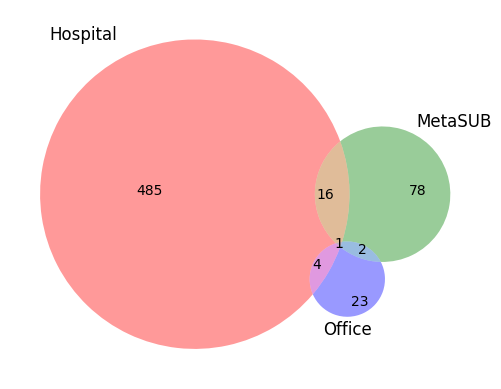

In [18]:
# Get the interactions from the dataframes
interactions_hospital = set(zip(edges["Hospital"]["v1"], edges["Hospital"]["v2"]))
interactions_meta = set(zip(edges["MetaSUB"]["v1"], edges["MetaSUB"]["v2"]))
interactions_office = set(zip(edges["Office"]["v1"], edges["Office"]["v2"]))

# Create the Venn diagram
venn3([interactions_hospital, interactions_meta, interactions_office], ('Hospital', 'MetaSUB', 'Office'))

# Display the Venn diagram
plt.savefig(figure_path + 'Fig_3D.svg', format='svg')
plt.show()

In [19]:
# Find the common edge (only one!)
interactions_all = interactions_hospital.intersection(interactions_meta, interactions_office)
interactions_all

{('Brevibacterium casei', 'Enhydrobacter aerosaccus')}

In [20]:
# Load the data files
file_path = "/mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Output_data/phyloseq_source/"
org_list = {}

# Listing the organisms from each environment (as present in the filtered data)
for env in environments:
    data = pd.read_csv(file_path + env + "_filtered_data.csv", sep = ",")
    org_list[env] = data["Species"].to_list()

# Getting the taxa binary data
org_df = pd.read_csv(output_path + "taxa_binary.csv", sep = ",", index_col = 0)
org_df

,Hospital,MetaSUB,Office
Abiotrophia defectiva,1,0,1
Achromobacter xylosoxidans,1,0,0
Acinetobacter baumannii,1,0,0
Acinetobacter johnsonii,1,1,0
Acinetobacter junii,1,0,1
...,...,...,...
Stutzerimonas stutzeri,1,1,1
Veillonella atypica,1,0,0
Veillonella parvula,1,1,0
Xanthomonas citri,1,0,0


In [21]:
# Presence/absence dataframe for the edges of the environments
edges_list = [interactions_hospital, interactions_meta, interactions_office]

# Create an empty dictionary to store the presence/absence data
edge_dict = {}

# Iterate over each set and create a dictionary entry with the set name as the key
for i, s in enumerate(edges_list):
    set_name = environments[i]
    # Create a dictionary where keys are element names and values are 1 if the element is present, else 0
    edge_dict[set_name] = {element: 1 if element in s else 0 for element in set.union(*edges_list)}

# Create a dataframe from the dictionary with set items as index
edges_df = pd.DataFrame(edge_dict).sort_index()
edges_df.to_csv(output_path + "edges_binary.csv", sep = "\t")

edges_df

Hospital  MetaSUB  \
Abiotrophia defectiva       Actinomyces viscosus               1        0   
                            Haemophilus parainfluenzae         1        0   
                            Neisseria sicca                    1        0   
                            Proteus mirabilis                  1        0   
                            Rothia mucilaginosa                1        0   
...                                                          ...      ...   
Streptococcus parasanguinis Stutzerimonas stutzeri             1        0   
                            Veillonella atypica                1        0   
                            Veillonella parvula                1        0   
Streptococcus salivarius    Veillonella atypica                1        0   
Streptococcus sanguinis     Veillonella parvula                1        0   

                                                        Office  
Abiotrophia defectiva       Actinomyces viscosus             0  
                            Haemophilus parainfluenzae       0  
                            Neisseria sicca                  0  
                            Proteus mirabilis                0  
                            Rothia mucilaginosa              0  
...                                                        ...  
Streptococcus parasanguinis Stutzerimonas stutzeri           0  
                            Veillonella atypica              0  
                            Veillonella parvula              0  
Streptococcus salivarius    Veillonella atypica              0  
Streptococcus sanguinis     Veillonella parvula              0  

[609 rows x 3 columns]

In [22]:
# Finding edge distribution
edge_details = pd.DataFrame(columns=["Environment", "Generalised", "Speciealised_both", 
                                     "Specialised_only_one", "Specialised_gen_edge"])

# Iterate over environments
for environment in environments:
    ge, se0, se1, se2 = 0, 0, 0, 0
    
    # Iterate over rows in the current environment
    for index, row in edges.get(environment, pd.DataFrame()).iterrows():
        if (row["v1"], row["v2"]) in edges_df.index:
            match = edges_df.loc[(row["v1"], row["v2"])]
            if match.sum() > 1:
                ge += 1
            else:
                test_list = [row["v1"], row["v2"]]
                selected_df = org_df.loc[org_df.index.isin(test_list)]
                sums = tuple(selected_df.sum(axis=1).to_list())
                if sums == (1, 1):
                    se0 += 1
                elif any((a == 1 and b > 1) or (a > 1 and b == 1) for a, b in [sums]):
                    se1 += 1
                elif any((a > 1 and b > 1) for a, b in [sums]):
                    se2 += 1
    
    # Append results to the output DataFrame
    edge_details.loc[len(edge_details)] = [environment, ge, se0, se1, se2]

edge_details.set_index("Environment", inplace=True)
edge_details

,Generalised,Speciealised_both,Specialised_only_one,Specialised_gen_edge
Environment,,,,
Hospital,21,95,228,162
MetaSUB,19,10,37,31
Office,7,2,18,3


In [23]:
# Define a function to convert values to percentages and normalize row-wise
def normalize_row_wise(row):
    total = row.sum()
    return row.apply(lambda x: (x / total) * 100 if total != 0 else 0)

edge_details_per = edge_details.apply(normalize_row_wise, axis=1)


edge_details_per

,Generalised,Speciealised_both,Specialised_only_one,Specialised_gen_edge
Environment,,,,
Hospital,4.150198,18.774704,45.059289,32.015810
MetaSUB,19.587629,10.309278,38.144330,31.958763
Office,23.333333,6.666667,60.000000,10.000000


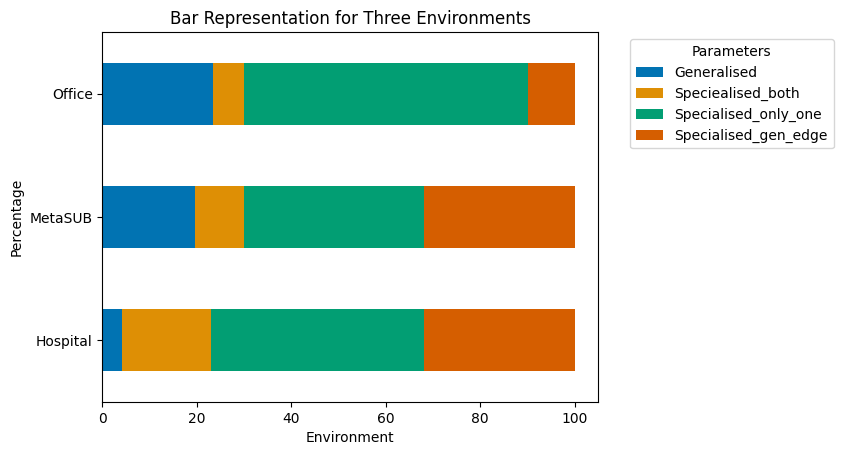

In [24]:
# Providing color palette for the plot
palette = sns.color_palette("colorblind")

# Plot the bar graph
edge_details_per.plot(kind='barh', stacked=True, color=palette)
plt.title('Bar Representation for Three Environments')
plt.xlabel('Environment')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.legend(title='Parameters', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig(figure_path + 'Fig_3E.svg', format='svg', bbox_inches='tight')
plt.show()

In [25]:
# Fetching the interactions in the genus level
genus_edge = {environment: edges[environment][['v1', 'v2']].apply(lambda x: x.str.split().str[0]) for environment in environments}

# Loading the all taxonomic information
taxa_data = pd.read_csv(output_path + "phyloseq_source/all_filtered_taxa.csv", sep=",")

# Map the genus to family
genus_to_family_mapping = taxa_data.set_index('genus')['class'].to_dict()
for environment in environments:
    genus_edge[environment]['v1'] = genus_edge[environment]['v1'].map(genus_to_family_mapping)
    genus_edge[environment]['v2'] = genus_edge[environment]['v2'].map(genus_to_family_mapping)

# Display the modified Dataframes
genus_edge["Hospital"]

,v1,v2
0,Bacilli,Actinomycetes
1,Bacilli,Gammaproteobacteria
2,Bacilli,Betaproteobacteria
3,Bacilli,Gammaproteobacteria
4,Bacilli,Actinomycetes
...,...,...
501,Bacilli,Gammaproteobacteria
502,Bacilli,Negativicutes
503,Bacilli,Negativicutes
504,Bacilli,Negativicutes


In [26]:
# Initialize a dictionary to store the matrices
matrices = {}

# Iterate over the dataframes to identify the class-level interactions
for environment, df in genus_edge.items():

    # Get all unique elements
    unique_elements = sorted(set(df['v1'].astype(str)).union(df['v2'].astype(str)))
    
    # Create a matrix with all-vs-all unique elements
    matrix = pd.DataFrame(0, columns=unique_elements, index=unique_elements)
    
    # Fill in the matrix
    for _, row in df.iterrows():
        v1 = str(row['v1'])  
        v2 = str(row['v2'])  
        matrix.loc[v1, v2] += 1
        matrix.loc[v2, v1] += 1
    
    # Convert the matrix to a lower triangular matrix
    lower_triangular_matrix = np.tril(matrix)

    # Convert the lower triangular matrix to a DataFrame
    lower_triangular_df = pd.DataFrame(lower_triangular_matrix, index=unique_elements, columns=unique_elements, dtype=int)
    lower_triangular_df = lower_triangular_df.fillna(0)
    
    # Store the matrix in the dictionary
    matrices[environment] = lower_triangular_df
    
    # removing nan rows and columns
    if 'nan' in matrices[environment].columns and 'nan' in matrices[environment].index:
        matrices[environment].drop(index=['nan'], inplace=True)
        matrices[environment].drop(columns=['nan'], inplace=True)  

    # Saving the class-to-class matrix
    matrices[environment].to_csv(output_path + "network_files/class_interactions/" + environment + "_class_matrix.csv", sep = "\t")

# Display the matrices
matrices["Hospital"]

,Actinomycetes,Alphaproteobacteria,Bacilli,Bacteroidia,Betaproteobacteria,Clostridia,Coriobacteriia,Flavobacteriia,Gammaproteobacteria,Negativicutes,Tissierellia
Actinomycetes,112,0,0,0,0,0,0,0,0,0,0
Alphaproteobacteria,17,4,0,0,0,0,0,0,0,0,0
Bacilli,97,12,72,0,0,0,0,0,0,0,0
Bacteroidia,15,1,15,8,0,0,0,0,0,0,0
Betaproteobacteria,6,1,5,0,0,0,0,0,0,0,0
Clostridia,2,1,2,3,0,0,0,0,0,0,0
Coriobacteriia,4,0,1,2,0,0,0,0,0,0,0
Flavobacteriia,5,1,2,0,0,0,0,0,0,0,0
Gammaproteobacteria,59,12,40,9,7,1,1,2,70,0,0
Negativicutes,8,1,10,4,3,0,0,0,4,0,0


In [27]:
# # Find the largest Dataframe
# largest_df = max(matrices.values(), key=lambda x: x.shape[0] * x.shape[1])

# # Iterate over other dataframes and align their values to the index of the largest dataframe
# for name, df in matrices.items():
#     if df is not largest_df:
        
#         # Reindex rows and columns
#         df = df.reindex(index=largest_df.index, columns=largest_df.columns, fill_value=0)
#         matrices[name] = df

# # Return all dataframes in a dictionary format
# matrices["MetaSUB"]

In [28]:
# Load hub files
hub_path = input_path + "hub_files/"

# Create an empty dictionary to store the hub files
hub_dict = {}

# Iterate over each environment and load the hub files
for env in environments:
    temp_df = pd.read_csv(hub_path + env + "_hubs.tsv", sep = ",")

    # Finding unique organisms
    unique_organisms = np.unique(temp_df.iloc[:, ::2].values.flatten())
    #print(len(unique_organisms))

    # Split the hub column into a proper dataframe
    hub_info = [
    {
        'degree1': temp_df[temp_df['Organism'] == element]['degree1'].values[0] if element in temp_df['Organism'].values else 0,
        'between1': temp_df[temp_df['Organism.1'] == element]['between1'].values[0] if element in temp_df['Organism.1'].values else 0,
        'close1': temp_df[temp_df['Organism.2'] == element]['close1'].values[0] if element in temp_df['Organism.2'].values else 0,
        'eigenv1': temp_df[temp_df['Organism.3'] == element]['eigenv1'].values[0] if element in temp_df['Organism.3'].values else 0   
    }
    for element in unique_organisms
    ]

    # Create a dataframe from the dictionary
    ind_hub_df = pd.DataFrame(hub_info, index=unique_organisms)
    ind_hub_df = ind_hub_df[ind_hub_df.sum(axis=1) != 0]

    # Change column names
    column_names = [env + '_Degree', env + '_Betweenness', env + '_Closeness', env + '_Eigenvector']
    ind_hub_df.columns = column_names
    ind_hub_df = ind_hub_df.round(2)

    # Store the dataframe in the dictionary
    hub_dict[env] = ind_hub_df

    # Save the dataframe
    ind_hub_df.to_csv(output_path + "network_files/hub_files/" + env + "_hubs_v2.tsv", sep = "\t")

# merging all hub files
hub_merged = pd.concat(hub_dict.values(), axis=1, keys=hub_dict.keys())

# Modifiying necessarily
hub_merged = hub_merged.fillna(0)
hub_merged = hub_merged.sort_index()

# Display the merged hub file
hub_merged.to_csv(output_path + "network_files/hub_files/hub_merged.tsv", sep = "\t")
hub_merged

Hospital                       \
                                 Hospital_Degree Hospital_Betweenness   
Acinetobacter baumannii                     0.00                 0.05   
Acinetobacter johnsonii                     0.00                 0.00   
Acinetobacter lwoffii                       0.00                 0.00   
Acinetobacter parvus                        0.00                 0.00   
Bifidobacterium longum                      0.30                 0.00   
Brachybacterium muris                       0.00                 0.00   
Brevibacterium casei                        0.00                 0.00   
Caulobacter vibrioides                      0.00                 0.00   
Chroococcidiopsis thermalis                 0.00                 0.00   
Corynebacterium matruchotii                 0.00                 0.04   
Corynebacterium pseudogenitalium            0.00                 0.00   
Cutibacterium acnes                         0.28                 0.04   
Deinococcus wulumuqiensis                   0.00                 0.00   
Enhydrobacter aerosaccus                    0.28                 0.00   
Escherichia coli                            0.00                 0.04   
Klebsiella pneumoniae                       0.30                 0.00   
Kocuria sp. UCD-OTCP                        0.00                 0.00   
Kytococcus sedentarius                      0.00                 0.00   
Lautropia mirabilis                         0.00                 0.00   
Methylobacterium radiotolerans              0.00                 0.10   
Methylorubrum populi                        0.00                 0.00   
Microbacterium laevaniformans               0.00                 0.00   
Micrococcus luteus                          0.31                 0.09   
Mycolicibacterium fortuitum                 0.00                 0.00   
Rothia dentocariosa                         0.30                 0.00   
Rothia mucilaginosa                         0.28                 0.06   
Serratia marcescens                         0.00                 0.00   
Sphingobium yanoikuyae                      0.00                 0.00   
Staphylococcus aureus                       0.34                 0.04   
Staphylococcus capitis                      0.30                 0.04   
Staphylococcus epidermidis                  0.28                 0.00   
Veillonella parvula                         0.00                 0.05   

                                                                          \
                                 Hospital_Closeness Hospital_Eigenvector   
Acinetobacter baumannii                        0.00                 0.00   
Acinetobacter johnsonii                        0.00                 0.00   
Acinetobacter lwoffii                          0.00                 0.00   
Acinetobacter parvus                           0.00                 0.00   
Bifidobacterium longum                         0.86                 0.85   
Brachybacterium muris                          0.00                 0.00   
Brevibacterium casei                           0.00                 0.00   
Caulobacter vibrioides                         0.00                 0.00   
Chroococcidiopsis thermalis                    0.00                 0.00   
Corynebacterium matruchotii                    0.00                 0.00   
Corynebacterium pseudogenitalium               0.00                 0.00   
Cutibacterium acnes                            0.86                 0.86   
Deinococcus wulumuqiensis                      0.00                 0.00   
Enhydrobacter aerosaccus                       0.00                 0.00   
Escherichia coli                               0.00                 0.00   
Klebsiella pneumoniae                          0.87                 0.88   
Kocuria sp. UCD-OTCP                           0.00                 0.00   
Kytococcus sedentarius                         0.00                 0.00   
Lautropia mirabilis                  

In [29]:
# Load the genome information file
genome_info = pd.read_csv(output_path + 'genome_details.csv', sep=',', index_col="organism_name")
genome_info = genome_info[["assembly_accession"]]

# Matching index
matching_indexes = [index for index in genome_info.index if any(string in index for string in hub_merged.index)]

# Selecting the matching indexes
genome_info = genome_info.loc[matching_indexes]

# Saving the genome information
genome_info.to_csv(output_path + "network_files/hub_files/genome_info_hubs.tsv", sep = "\t")
genome_info

,assembly_accession
organism_name,
Acinetobacter baumannii,GCF_000369385.1
Acinetobacter johnsonii,GCF_016027055.1
Acinetobacter lwoffii,GCF_019048305.1
Acinetobacter parvus,GCF_000248155.1
Bifidobacterium longum,GCF_017132775.1
Brachybacterium muris,GCF_016907455.1
Brevibacterium casei,GCF_900169275.1
Caulobacter vibrioides,GCF_002858865.1
Chroococcidiopsis thermalis,GCF_000317125.1


In [30]:
# Load the abundance file paths
abundance_path = output_path + "phyloseq_source/all_filtered_data.csv"
metadata_path = output_path + "phyloseq_source/all_filtered_metadata.csv"

# Load the abundance and metadata dataframes
abundance_data = pd.read_csv(abundance_path, sep=",", index_col="Species")
metadata = pd.read_csv(metadata_path, sep=",", index_col="Illumina Library ID")

# Store the captured hub abundance
hub_abundance = {}

for env in environments:
    nodes = list(hub_merged.index)
    id = list(metadata[metadata['Environment'] == env].index)
    abundance = abundance_data.loc[nodes, id]
    abundance_mean = list(abundance.mean(axis=1))
    hub_abundance[env] = abundance_mean

# Convert dictionary of abundance data into DataFrame
hub_abundance_df = pd.DataFrame(hub_abundance, index=nodes)

# Amplify abundance values
hub_abundance_df *= 100000

# Apply logarithm transformation to non-zero values
hub_abundance_df[hub_abundance_df != 0] = np.log2(hub_abundance_df[hub_abundance_df != 0])
hub_abundance_df = hub_abundance_df.round(3)

# Save DataFrame 
hub_abundance_df.to_csv(output_path + "network_files/hub_files/hub_abundance.tsv", sep="\t")

hub_abundance_df

,Hospital,MetaSUB,Office
Acinetobacter baumannii,10.588,5.878,5.245
Acinetobacter johnsonii,6.173,8.494,6.185
Acinetobacter lwoffii,1.879,9.195,0.000
Acinetobacter parvus,1.830,3.885,9.342
Bifidobacterium longum,9.677,5.020,0.000
Brachybacterium muris,0.000,7.613,0.000
Brevibacterium casei,7.225,7.817,10.054
Caulobacter vibrioides,3.497,10.777,9.328
Chroococcidiopsis thermalis,5.698,10.432,4.802
Corynebacterium matruchotii,8.169,9.795,6.342


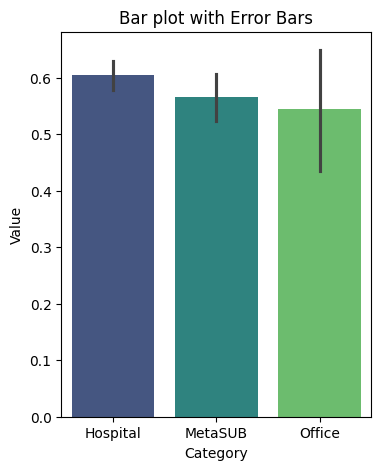

In [31]:
# Store the captured abundance via network nodes
captured_abundance = {}

for env in environments:
    nodes = list(pd.concat([edges[env]['v1'], edges[env]['v2']]).unique())
    id = list(metadata[metadata['Environment'] == env].index)
    abundance = abundance_data.loc[nodes, id]
    abundance_sum = list(abundance.sum(axis=0))
    captured_abundance[env] = abundance_sum

combined_data = pd.concat({k: pd.Series(v) for k, v in captured_abundance.items()}).reset_index()
combined_data.columns = ['Category', 'Index', 'Value']  # Rename columns

# Plot
plt.figure(figsize=(4, 5))  
sns.barplot(x='Category', y='Value', palette= 'viridis', hue = 'Category', data=combined_data, errorbar = ("ci", 95))  # ci='sd' for error bars as standard deviation
plt.title('Bar plot with Error Bars')
plt.xlabel('Category')
plt.ylabel('Value')
plt.savefig(figure_path + 'Fig_3F.svg', format='svg')
plt.show()